 Аномалии, работа с признаками, пайплайны

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [6]:
def load_otp():
    features = pd.read_csv('data/descr.txt', sep='\t', encoding='cp1251', names=['feature', 'descr'])
    
    features = features.iloc[3:]
    feature_names = features.iloc[:, 0].values
    
    df_data_x = pd.read_csv('data/data_x.csv', sep=';', header=None, names=feature_names)
    df_data_x.loc[:, 'PREVIOUS_CARD_NUM_UTILIZED'] = df_data_x.PREVIOUS_CARD_NUM_UTILIZED.fillna(0)
    
    features.loc[:, 'uniq_vals'] = df_data_x.apply(lambda c: c.nunique(), axis=0).values
    
    features = features.reset_index(drop=True)
    
    df_data_y = pd.read_csv('data/data_y.csv', sep=';', names=['active'])
    
    idx = np.where(df_data_x.dtypes == 'object')[0]

    for i in idx:
        df_data_x.iloc[:, i] = df_data_x.iloc[:, i].str.replace(',', '.').astype('float')
        
    df_data = df_data_x.join(df_data_y)
    
    return df_data, features

## Hyperparameter Search

Давайте для задачи по ОТП сделаем end-to-end pipeline

<img src='img/pipeline.png'>

In [7]:
df, features = load_otp()

In [8]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc


def plot_roc_curve(predictions, yval):
    try:
        preds = predictions[:,1]
    except:
        preds = np.array(predictions)
    fpr, tpr, threshold = roc_curve(yval, preds)
    roc_auc = auc(fpr, tpr)
    with plt.rc_context({'xtick.color':'white', 'ytick.color':'white',
                     'axes.labelcolor':'white'}):
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [9]:
RND_SEED = 123

In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col_idx):
        self.col_idx = col_idx
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[:, self.col_idx]

In [11]:
cat_features = [6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 33]
binary_features = features[features.uniq_vals == 2].index.values
cont_features = np.setdiff1d(np.arange(50), cat_features)
cont_features = np.setdiff1d(cont_features, binary_features)

### Подбор гиперпараметров

<img src='img/gridsearch.jpeg'>

In [12]:
from scipy.stats import randint as sp_randint

X = df.iloc[:, :-1].fillna(0)
y = df.iloc[:, -1].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_train.shape, X_test.shape

((10656, 50), (4567, 50))

In [14]:
model = LogisticRegression()
param_grid = { "penalty"      : ['l1', 'l2'],
               "C"      : np.linspace(0.00001, 100, 1),
               "class_weight"         : [None, 'balanced']
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

model = LogisticRegression(**grid_search.best_params_)
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logi

{'C': 1e-05, 'class_weight': 'balanced', 'penalty': 'l2'}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression(C=1e-05, class_weight='balanced')

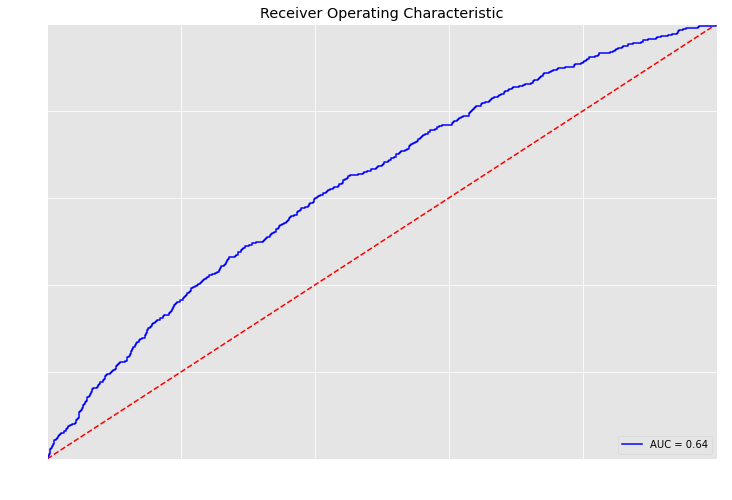

In [15]:
plot_roc_curve(model.predict_proba(X_test), y_test)